In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date, timedelta


# Creating Master Table

In [2]:
cab_data = pd.read_csv('ds/Cab_Data.csv')
city = pd.read_csv('ds/city.csv')
city.Users = city.Users.apply(lambda v: v.replace(',', '')).astype('int32')
city.Population = city.Population.apply(lambda v: v.replace(',', '')).astype('int32')
customer_id = pd.read_csv('ds/customer_id.csv')
transaction_id = pd.read_csv('ds/transaction_id.csv')
print(cab_data.shape, ', ', list(cab_data.columns))
print(city.shape, ', ',city.columns)
print(customer_id.shape, ', ',customer_id.columns)
print(transaction_id.shape, ', ',transaction_id.columns)

(359392, 7) ,  ['Transaction ID', 'Date of Travel', 'Company', 'City', 'KM Travelled', 'Price Charged', 'Cost of Trip']
(20, 3) ,  Index(['City', 'Population', 'Users'], dtype='object')
(49171, 4) ,  Index(['Customer ID', 'Gender', 'Age', 'Income (USD/Month)'], dtype='object')
(440098, 3) ,  Index(['Transaction ID', 'Customer ID', 'Payment_Mode'], dtype='object')


In [3]:
'''
Cab Data columns has intersection with Transaction ID and City columns.
After Merging them based on inner join, They will have intersection with Customer ID table and
We can Merge them as well.
'''

# a = set(cab_data.columns)
# b = set(customer_id.columns)
# a.intersection(transaction_id)

master = pd.merge(cab_data, city, on=["City"], how='inner')
master = master.rename(columns={'Population':'City_Population', 'Users':'City_Users'})
master = pd.merge(master, transaction_id, on=["Transaction ID"], how='inner')
master = pd.merge(master, customer_id, on=["Customer ID"], how='inner')
master

,Transaction ID,Date of Travel,Company,City,KM Travelled,Price Charged,Cost of Trip,City_Population,City_Users,Customer ID,Payment_Mode,Gender,Age,Income (USD/Month)
0,10000011,42377,Pink Cab,ATLANTA GA,30.45,370.95,313.6350,814885,24701,29290,Card,Male,28,10813
1,10351127,43302,Yellow Cab,ATLANTA GA,26.19,598.70,317.4228,814885,24701,29290,Cash,Male,28,10813
2,10412921,43427,Yellow Cab,ATLANTA GA,42.55,792.05,597.4020,814885,24701,29290,Card,Male,28,10813
3,10000012,42375,Pink Cab,ATLANTA GA,28.62,358.52,334.8540,814885,24701,27703,Card,Male,27,9237
4,10320494,43211,Yellow Cab,ATLANTA GA,36.38,721.10,467.1192,814885,24701,27703,Card,Male,27,9237
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359387,10307228,43162,Yellow Cab,WASHINGTON DC,38.40,668.93,525.3120,418859,127001,51406,Cash,Female,29,6829
359388,10319775,43203,Yellow Cab,WASHINGTON DC,3.57,67.60,44.5536,418859,127001,51406,Cash,Female,29,6829
359389,10347676,43287,Yellow Cab,WASHINGTON DC,23.46,331.97,337.8240,418859,127001,51406,Card,Female,29,6829
359390,10358624,43314,Yellow Cab,WASHINGTON DC,27.60,358.23,364.3200,418859,127001,51406,Cash,Female,29,6829


# Turning Date of Travel Column type to DateTime Format

In [4]:
# Time period of data is from 31/01/2016 to 31/12/2018.
f_date = date(2016, 1, 31)
l_date = date(2018, 12, 31)
delta = l_date - f_date
print('Number of Different Days Based on Given Time Period: ', delta.days)
print('Number of Different Days in Data: ', master['Date of Travel'].nunique())
print('Difference: ', master['Date of Travel'].nunique() - delta.days)

Number of Different Days Based on Given Time Period:  1065
Number of Different Days in Data:  1095
Difference:  30


`Date of Travel` values range is from 42371 to 43465, Which is more than 1065 days.<br>
We need to remove extra 30 days data from our table. So we consider dates from 42401 to 43465.<br>
Then we map each date between (2016, 1, 31) and (2018, 12, 31) to values from 42401 to 43465.<br>

In [5]:
master = master[master['Date of Travel'].isin(np.sort(master['Date of Travel'].unique())[30:])]

In [6]:
f_date = date(2016, 1, 31)
l_date = date(2018, 12, 31)
a = np.sort(master['Date of Travel'].unique())
b = pd.date_range(f_date,l_date-timedelta(days=1),freq='d')
mapping = dict(list(list(zip(a,b))))
map_func = lambda val: mapping[val]
result = master['Date of Travel'].apply(map_func)
master = master.assign(date=result)
master = master.drop(columns=['Transaction ID', 'Date of Travel'])
print(master.shape)
master.head()

(354746, 13)


,Company,City,KM Travelled,Price Charged,Cost of Trip,City_Population,City_Users,Customer ID,Payment_Mode,Gender,Age,Income (USD/Month),date
1,Yellow Cab,ATLANTA GA,26.19,598.70,317.4228,814885,24701,29290,Cash,Male,28,10813,2018-07-20
2,Yellow Cab,ATLANTA GA,42.55,792.05,597.4020,814885,24701,29290,Card,Male,28,10813,2018-11-22
4,Yellow Cab,ATLANTA GA,36.38,721.10,467.1192,814885,24701,27703,Card,Male,27,9237,2018-04-20
5,Yellow Cab,ATLANTA GA,6.18,138.40,87.5088,814885,24701,27703,Cash,Male,27,9237,2018-05-03
6,Pink Cab,ATLANTA GA,13.39,167.03,141.9340,814885,24701,27703,Card,Male,27,9237,2018-10-26


# Extracting useful information from Date

In [7]:
# Extracting week of year from date, varies from 1 to 52
master['dt_week'] = master['date'].dt.isocalendar().week

# Extracting month from date - 1 to 12
master['dt_month'] = master['date'].dt.month

# Extract quarter from date variable - 1 to 4
master['dt_quarter'] = master['date'].dt.quarter

# We could also extract semester
master['dt_semester'] = np.where(master['dt_quarter'].isin([1,2]), 1, 2)


# extract year 
master['dt_year'] = master['date'].dt.isocalendar().year

# day of the week - from 0 to 6
master['dt_dayofweek'] = master['date'].dt.dayofweek

master.head()

,Company,City,KM Travelled,Price Charged,Cost of Trip,City_Population,City_Users,Customer ID,Payment_Mode,Gender,Age,Income (USD/Month),date,dt_week,dt_month,dt_quarter,dt_semester,dt_year,dt_dayofweek
1,Yellow Cab,ATLANTA GA,26.19,598.70,317.4228,814885,24701,29290,Cash,Male,28,10813,2018-07-20,29,7,3,2,2018,4
2,Yellow Cab,ATLANTA GA,42.55,792.05,597.4020,814885,24701,29290,Card,Male,28,10813,2018-11-22,47,11,4,2,2018,3
4,Yellow Cab,ATLANTA GA,36.38,721.10,467.1192,814885,24701,27703,Card,Male,27,9237,2018-04-20,16,4,2,1,2018,4
5,Yellow Cab,ATLANTA GA,6.18,138.40,87.5088,814885,24701,27703,Cash,Male,27,9237,2018-05-03,18,5,2,1,2018,3
6,Pink Cab,ATLANTA GA,13.39,167.03,141.9340,814885,24701,27703,Card,Male,27,9237,2018-10-26,43,10,4,2,2018,4


In [8]:
master = master.sort_values(by=['date'], ignore_index=True)
master.head()

,Company,City,KM Travelled,Price Charged,Cost of Trip,City_Population,City_Users,Customer ID,Payment_Mode,Gender,Age,Income (USD/Month),date,dt_week,dt_month,dt_quarter,dt_semester,dt_year,dt_dayofweek
0,Yellow Cab,BOSTON MA,31.32,548.89,383.3568,248968,80021,58014,Card,Female,39,16479,2016-01-31,4,1,1,1,2016,6
1,Yellow Cab,LOS ANGELES CA,15.12,334.13,181.4400,1595037,144132,6904,Card,Male,62,8174,2016-01-31,4,1,1,1,2016,6
2,Yellow Cab,NEW YORK NY,18.36,530.70,244.5552,8405837,302149,2141,Cash,Female,44,10243,2016-01-31,4,1,1,1,2016,6
3,Yellow Cab,BOSTON MA,5.05,97.16,65.4480,248968,80021,59993,Card,Female,35,19747,2016-01-31,4,1,1,1,2016,6
4,Yellow Cab,LOS ANGELES CA,25.53,402.89,327.8052,1595037,144132,7219,Cash,Male,18,13980,2016-01-31,4,1,1,1,2016,6


In [9]:
master['profit'] = master['Price Charged'] - master['Cost of Trip']

In [10]:

pink = master[master['Company'] == 'Pink Cab']
yellow = master[master['Company'] == 'Yellow Cab']


In [125]:
master.shape

(354746, 20)

# Profit of a company in each year

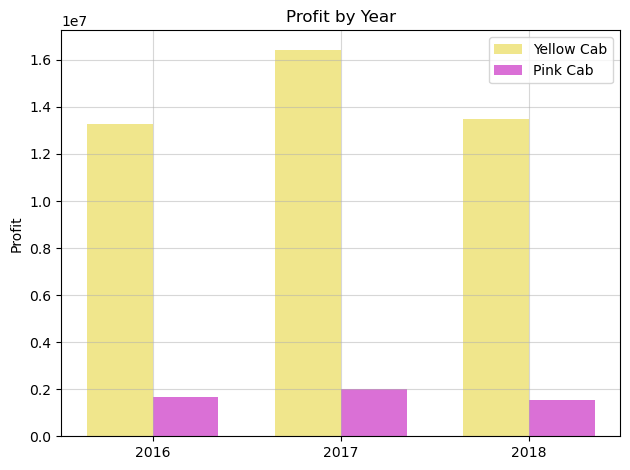

In [32]:
yprofit = yellow.groupby(['dt_year']).profit.sum()
pprofit = pink.groupby(['dt_year']).profit.sum()
labels = master.dt_year.unique().to_numpy()

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, yprofit, width, label='Yellow Cab', color='khaki')
rects2 = ax.bar(x + width/2, pprofit, width, label='Pink Cab', color='orchid')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Profit')
ax.set_title('Profit by Year')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.5)
ax.legend()

# ax.bar_label(rects1, padding=3)
# ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

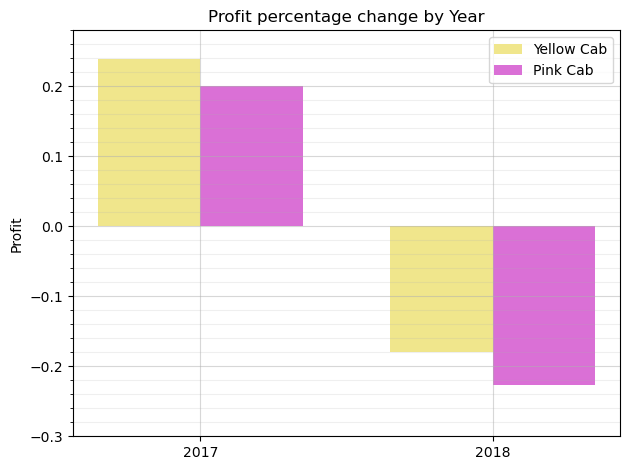

In [30]:
yprofit = yellow.groupby(['dt_year']).profit.sum().pct_change()[1:]
pprofit = pink.groupby(['dt_year']).profit.sum().pct_change()[1:]
labels = master.dt_year.unique().to_numpy()[1:]
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, yprofit, width, label='Yellow Cab', color='khaki')
rects2 = ax.bar(x + width/2, pprofit, width, label='Pink Cab', color='orchid')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Profit')
ax.set_title('Profit percentage change by Year')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.grid()
ax.set_yticks(np.arange(-0.3, 0.3, 0.1))
ax.set_yticks(np.arange(-0.3, 0.3, 0.02), minor=True)
# ax.set_xticks(np.arange(0, epochs+1, 5))
# ax.set_xticks(np.arange(0, epochs+1, 1), minor=True)

ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.5)
    

fig.tight_layout()

plt.show()

# 1. Is pink cab progress is better than yellow cab in quarters?


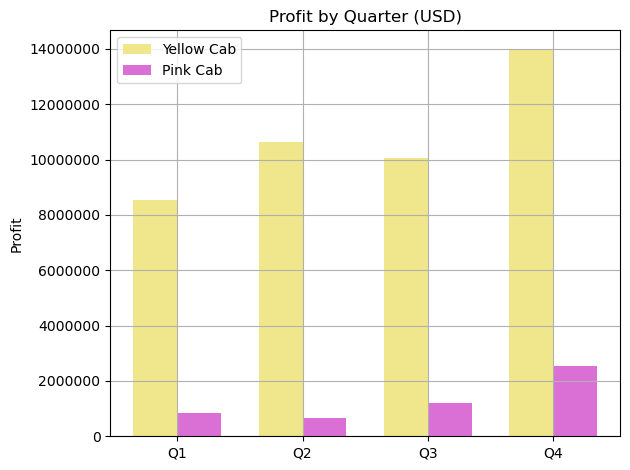

In [43]:
yprofit = yellow.groupby(['dt_quarter']).profit.sum()
pprofit = pink.groupby(['dt_quarter']).profit.sum()
labels = master.dt_quarter.unique()

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, yprofit, width, label='Yellow Cab', color='khaki')
rects2 = ax.bar(x + width/2, pprofit, width, label='Pink Cab', color='orchid')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Profit')
ax.set_title('Profit by Quarter (USD)')
ax.set_xticks(x)
labels = list(map(lambda q: "Q{0}".format(q), labels))

ax.set_xticklabels(labels)
ax.ticklabel_format(style='plain',axis='y')
ax.legend()
ax.grid()
# ax.bar_label(rects1, padding=3)
# ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

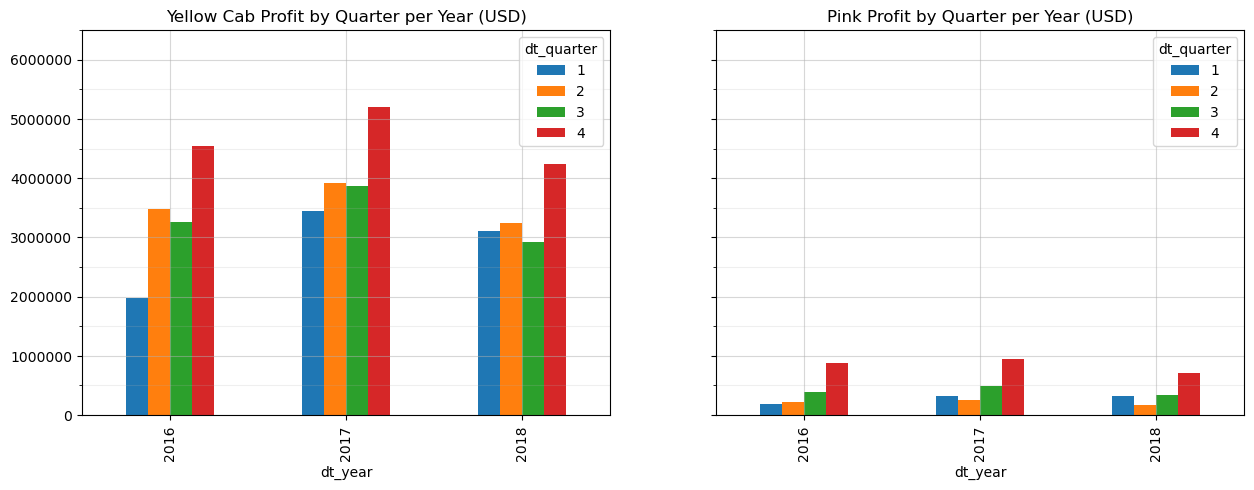

In [71]:

fig, (ax1, ax2) = plt.subplots(1, 2,  sharey=True,figsize=(15,5))

yellow.groupby(['dt_year','dt_quarter']).profit.sum().unstack().plot.bar(ax=ax1)
ax1.set_title('Yellow Cab Profit by Quarter per Year (USD)')
ax1.ticklabel_format(useOffset=False, style='plain',axis='y')
ax1.set_yticks(np.arange(0, 7000000,1000000))
ax1.set_yticks(np.arange(0, 7000000, 500000), minor=True)
ax1.grid(which='minor', alpha=0.2)
ax1.grid(which='major', alpha=0.5)

pink.groupby(['dt_year','dt_quarter']).profit.sum().unstack().plot.bar(ax=ax2)
ax2.set_title('Pink Profit by Quarter per Year (USD)')
ax2.ticklabel_format(useOffset=False, style='plain',axis='y')
ax2.set_yticks(np.arange(0, 7000000,1000000))
ax2.set_yticks(np.arange(0, 7000000, 500000), minor=True)
ax2.grid(which='minor', alpha=0.2)
ax2.grid(which='major', alpha=0.5)
plt.show()

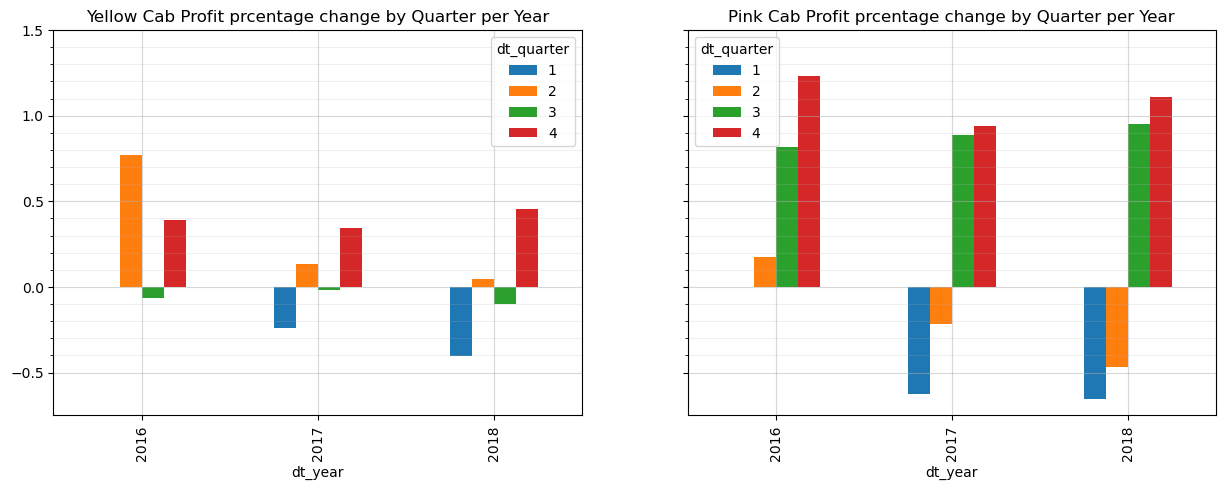

In [79]:
yellow.groupby(['dt_year','dt_quarter']).profit.sum().pct_change()



fig, (ax1, ax2) = plt.subplots(1, 2,  sharey=True,figsize=(15,5))

yellow.groupby(['dt_year','dt_quarter']).profit.sum().pct_change().unstack().plot.bar(ax=ax1)
ax1.set_title('Yellow Cab Profit prcentage change by Quarter per Year')
ax1.ticklabel_format(useOffset=False, style='plain',axis='y')
ax1.set_yticks(np.arange(-0.5, 1.6,0.5))
ax1.set_yticks(np.arange(-0.5, 1.6, 0.1), minor=True)
ax1.grid(which='minor', alpha=0.2)
ax1.grid(which='major', alpha=0.5)


pink.groupby(['dt_year','dt_quarter']).profit.sum().pct_change().unstack().plot.bar(ax=ax2)
ax2.set_title('Pink Cab Profit prcentage change by Quarter per Year')
ax2.ticklabel_format(useOffset=False, style='plain',axis='y')
ax2.set_yticks(np.arange(-0.5, 1.6,0.5))
ax2.set_yticks(np.arange(-0.5, 1.6, 0.1), minor=True)
ax2.grid(which='minor', alpha=0.2)
ax2.grid(which='major', alpha=0.5)
plt.show()

In [80]:
master.head()

,Company,City,KM Travelled,Price Charged,Cost of Trip,City_Population,City_Users,Customer ID,Payment_Mode,Gender,Age,Income (USD/Month),date,dt_week,dt_month,dt_quarter,dt_semester,dt_year,dt_dayofweek,profit
0,Yellow Cab,BOSTON MA,31.32,548.89,383.3568,248968,80021,58014,Card,Female,39,16479,2016-01-31,4,1,1,1,2016,6,165.5332
1,Yellow Cab,LOS ANGELES CA,15.12,334.13,181.4400,1595037,144132,6904,Card,Male,62,8174,2016-01-31,4,1,1,1,2016,6,152.6900
2,Yellow Cab,NEW YORK NY,18.36,530.70,244.5552,8405837,302149,2141,Cash,Female,44,10243,2016-01-31,4,1,1,1,2016,6,286.1448
3,Yellow Cab,BOSTON MA,5.05,97.16,65.4480,248968,80021,59993,Card,Female,35,19747,2016-01-31,4,1,1,1,2016,6,31.7120
4,Yellow Cab,LOS ANGELES CA,25.53,402.89,327.8052,1595037,144132,7219,Cash,Male,18,13980,2016-01-31,4,1,1,1,2016,6,75.0848


# 2. Is there any seasonality in number of customers using the cab service?



In [346]:
yellow.groupby(['dt_quarter']).size()

dt_quarter
1    46193
2    55000
3    72758
4    97011
dtype: int64

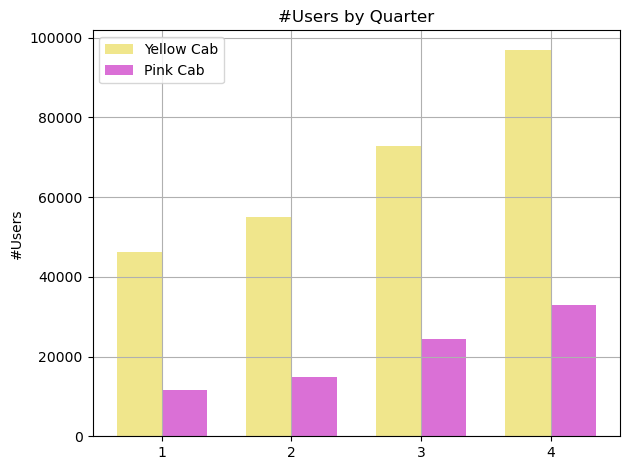

In [82]:
yprofit = yellow.groupby(['dt_quarter']).size()
pprofit = pink.groupby(['dt_quarter']).size()
labels = master.dt_quarter.unique()

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, yprofit, width, label='Yellow Cab', color='khaki')
rects2 = ax.bar(x + width/2, pprofit, width, label='Pink Cab', color='orchid')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('#Users')
ax.set_title('#Users by Quarter')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.ticklabel_format(style='plain',axis='y')
ax.legend()
ax.grid()

# ax.bar_label(rects1, padding=3)
# ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

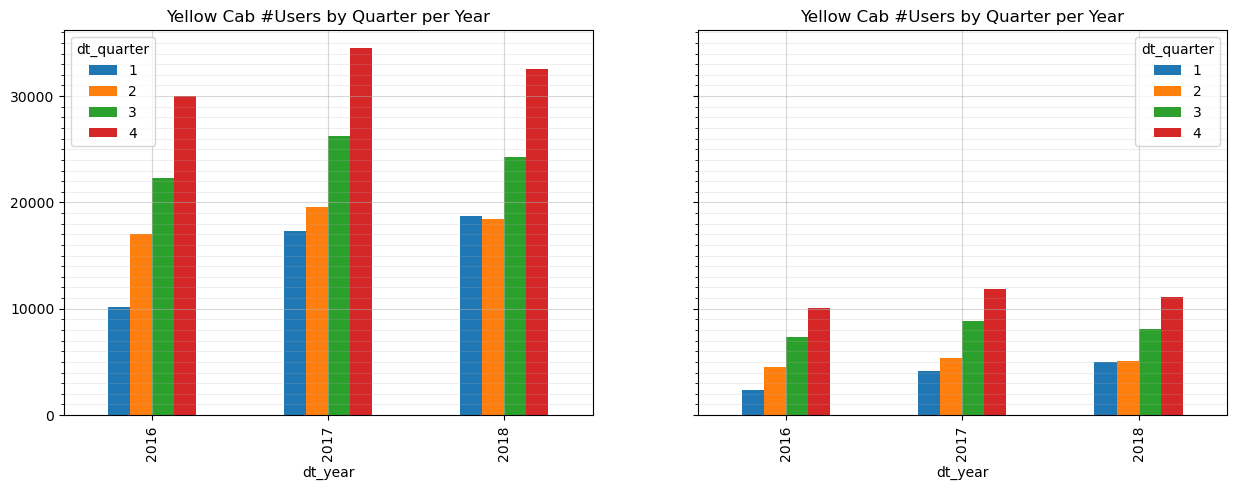

In [87]:
fig, (ax1, ax2) = plt.subplots(1, 2,  sharey=True,figsize=(15,5))


yellow.groupby(['dt_year','dt_quarter']).size().unstack().plot.bar(ax=ax1)
ax1.set_title('Yellow Cab #Users by Quarter per Year')
ax1.ticklabel_format(useOffset=False, style='plain',axis='y')
ax1.set_yticks(np.arange(0, 36001, 10000))
ax1.set_yticks(np.arange(0, 36001, 1000), minor=True)
ax1.grid(which='minor', alpha=0.2)
ax1.grid(which='major', alpha=0.5)


pink.groupby(['dt_year','dt_quarter']).size().unstack().plot.bar(ax=ax2)
ax2.set_title('Pink Cab #Users by Quarter per Year')
ax2.ticklabel_format(useOffset=False, style='plain',axis='y')
ax2.set_yticks(np.arange(0, 36001, 10000))
ax2.set_yticks(np.arange(0, 36001, 1000), minor=True)
ax2.grid(which='minor', alpha=0.2)
ax2.grid(which='major', alpha=0.5)
plt.show()

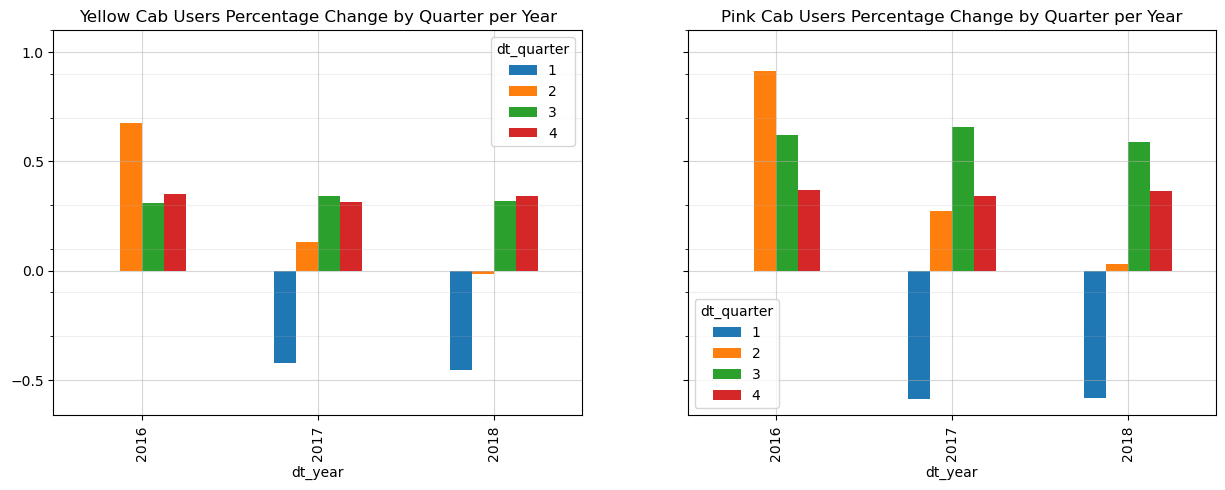

In [89]:
# Progress comparison of pink and yellow cab
fig, (ax1, ax2) = plt.subplots(1, 2,  sharey=True,figsize=(15,5))


yellow.groupby(['dt_year','dt_quarter']).size().pct_change().unstack().plot.bar(ax=ax1)
ax1.set_title('Yellow Cab Users Percentage Change by Quarter per Year')
ax1.ticklabel_format(useOffset=False, style='plain',axis='y')
ax1.set_yticks(np.arange(-0.5, 1.2, 0.5))
ax1.set_yticks(np.arange(-0.5, 1.2, 0.2), minor=True)
ax1.grid(which='minor', alpha=0.2)
ax1.grid(which='major', alpha=0.5)

pink.groupby(['dt_year','dt_quarter']).size().pct_change().unstack().plot.bar(ax=ax2)
ax2.set_title('Pink Cab Users Percentage Change by Quarter per Year')
ax2.ticklabel_format(useOffset=False, style='plain',axis='y')
ax2.set_yticks(np.arange(-0.5, 1.2, 0.5))
ax2.set_yticks(np.arange(-0.5, 1.2, 0.2), minor=True)
ax2.grid(which='minor', alpha=0.2)
ax2.grid(which='major', alpha=0.5)
plt.show()

In [350]:
master.head()

,Company,City,KM Travelled,Price Charged,Cost of Trip,City_Population,City_Users,Customer ID,Payment_Mode,Gender,Age,Income (USD/Month),date,dt_week,dt_month,dt_quarter,dt_semester,dt_year,dt_dayofweek,profit
0,Yellow Cab,BOSTON MA,31.32,548.89,383.3568,248968,80021,58014,Card,Female,39,16479,2016-01-31,4,1,1,1,2016,6,165.5332
1,Yellow Cab,LOS ANGELES CA,15.12,334.13,181.4400,1595037,144132,6904,Card,Male,62,8174,2016-01-31,4,1,1,1,2016,6,152.6900
2,Yellow Cab,NEW YORK NY,18.36,530.70,244.5552,8405837,302149,2141,Cash,Female,44,10243,2016-01-31,4,1,1,1,2016,6,286.1448
3,Yellow Cab,BOSTON MA,5.05,97.16,65.4480,248968,80021,59993,Card,Female,35,19747,2016-01-31,4,1,1,1,2016,6,31.7120
4,Yellow Cab,LOS ANGELES CA,25.53,402.89,327.8052,1595037,144132,7219,Cash,Male,18,13980,2016-01-31,4,1,1,1,2016,6,75.0848


# 3. Is there any city that pink performed better in term of profit per user?


In [91]:
a = yellow.groupby(['City']).profit.sum()
b = pink.groupby(['City']).profit.sum()


yellow_profit_per_user = []
pink_profit_per_user = []

for c in a.index:
    d = a[c] / city[city.City.isin([c])].Users.values[0]
    yellow_profit_per_user.append((c, d))
    e = b[c] / city[city.City.isin([c])].Users.values[0]
    pink_profit_per_user.append((c, e))
    
yellow_profit_per_user = dict(yellow_profit_per_user)
pink_profit_per_user = dict(pink_profit_per_user)

In [92]:
yprofit = yellow_profit_per_user
pprofit = pink_profit_per_user
labels = a.index

x = np.arange(len(labels))  # the label locations

print(list(zip(x, labels)))

[(0, 'ATLANTA GA'), (1, 'AUSTIN TX'), (2, 'BOSTON MA'), (3, 'CHICAGO IL'), (4, 'DALLAS TX'), (5, 'DENVER CO'), (6, 'LOS ANGELES CA'), (7, 'MIAMI FL'), (8, 'NASHVILLE TN'), (9, 'NEW YORK NY'), (10, 'ORANGE COUNTY'), (11, 'PHOENIX AZ'), (12, 'PITTSBURGH PA'), (13, 'SACRAMENTO CA'), (14, 'SAN DIEGO CA'), (15, 'SEATTLE WA'), (16, 'SILICON VALLEY'), (17, 'TUCSON AZ'), (18, 'WASHINGTON DC')]


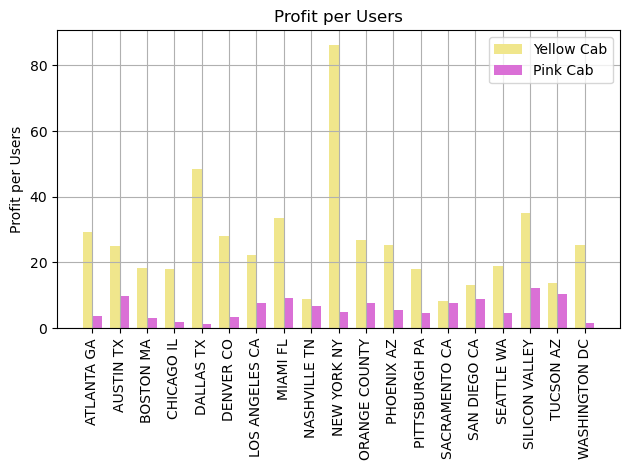

In [100]:

width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, yprofit.values(), width, label='Yellow Cab', color='khaki')
rects2 = ax.bar(x + width/2, pprofit.values(), width, label='Pink Cab', color='orchid')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Profit per Users')
ax.set_title('Profit per Users')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation='vertical')
ax.ticklabel_format(style='plain',axis='y')
ax.legend()
ax.grid()
# ax.bar_label(rects1, padding=3)
# ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

# 4. Did pink cab performed better in term of profit per kilometer?

In [103]:
a = yellow.groupby(['dt_year']).profit.sum()
b = pink.groupby(['dt_year']).profit.sum()
c = yellow.groupby(['dt_year'])['KM Travelled'].sum()
d = pink.groupby(['dt_year'])['KM Travelled'].sum()


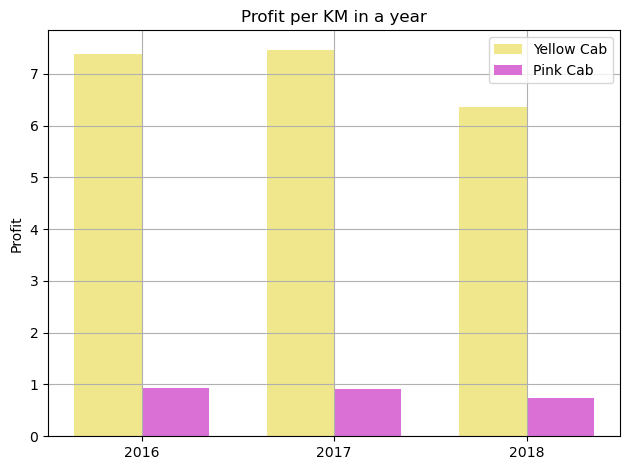

In [120]:
a = yellow.groupby(['dt_year']).profit.sum()
b = pink.groupby(['dt_year']).profit.sum()
c = yellow.groupby(['dt_year'])['KM Travelled'].sum()
d = pink.groupby(['dt_year'])['KM Travelled'].sum()


labels = master.dt_year.unique()

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, a/c, width, label='Yellow Cab', color='khaki')
rects2 = ax.bar(x + width/2, b/c, width, label='Pink Cab', color='orchid')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Profit')
ax.set_title('Profit per KM in a year')
ax.set_xticks(x)
ax.set_xticklabels(labels)
# ax.ticklabel_format(useOffset=False, style='plain',axis='y')
ax.legend()

# ax.bar_label(rects1, padding=3)
# ax.bar_label(rects2, padding=3)
ax.grid()
fig.tight_layout()

plt.show()

# 5. Is age of customer affects our profit?


In [106]:
yage = customer_id[customer_id['Customer ID'].isin(yellow['Customer ID'])].Age
page = customer_id[customer_id['Customer ID'].isin(pink['Customer ID'])].Age

yhists, yedges = np.histogram(yage, np.arange(yage.min(), yage.max()+5, 5))
phists, pedges = np.histogram(page, np.arange(page.min(), page.max()+5, 5))

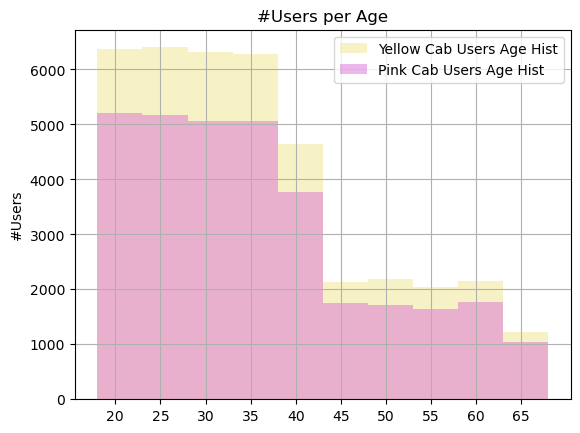

In [123]:
fig, ax = plt.subplots()

ax.hist(yage, np.arange(yage.min(), yage.max()+5, 5),label='Yellow Cab Users Age Hist',ls='dotted', lw=3, alpha=0.5, histtype='bar',color='khaki')
ax.hist(page, np.arange(page.min(), page.max()+5, 5),label='Pink Cab Users Age Hist', ls='dashed', lw=3, histtype='bar',alpha=0.5, color='orchid')
ax.set_ylabel('#Users')
ax.set_title('#Users per Age')
ax.set_xticks(np.arange(20,70,5))
# ax.set_xticklabels(labels)
ax.legend()
ax.grid()
plt.show()

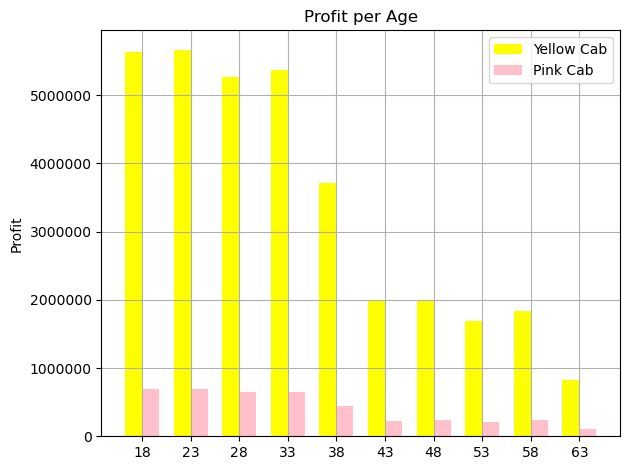

In [124]:
yellow_profit_by_age = []
s = yedges[0]
for e in yedges[1:]:
    r = yellow[(yellow.Age > s) & (yellow.Age < e)].profit.sum()
    yellow_profit_by_age.append(r)
    s = e
    

pink_profit_by_age = []
s = pedges[0]
for e in pedges[1:]:
    r = pink[(pink.Age > s) & (pink.Age < e)].profit.sum()
    pink_profit_by_age.append(r)
    s = e
    
    
    

labels = yedges[:-1]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, yellow_profit_by_age, width, label='Yellow Cab', color='yellow')
rects2 = ax.bar(x + width/2, pink_profit_by_age, width, label='Pink Cab', color='pink')

ax.set_ylabel('Profit')
ax.set_title('Profit per Age')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.ticklabel_format(style='plain',axis='y')
ax.legend()
ax.grid()
fig.tight_layout()

plt.show()

In [ ]:
'''
Is there any seasonality in number of customers using the cab service?
Is pink cab progress is better than yellow cab?
Is there any city that pink performed better in term of profit per user?
Did pink cab performed better in term of profit per kilometer?
Is age of customer affects our profit?
'''